In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy as sqla
import csv
import matplotlib.pyplot as plt

## DATABASE CONNECTION

In [2]:
DB_USER = "postgres"
DB_PASSWORD = "postgres"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "postgres"

connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Créer un moteur SQLAlchemy
engine = sqla.create_engine(connection_string)

# Tester la connexion
try:
    with engine.connect() as connection:
        print("Connected to PostgreSQL successfully!")
except Exception as e:
    print(f"Error: {e}")

connection = engine.connect()

Connected to PostgreSQL successfully!


## IMPORT DATA BY HOURS DAY

In [3]:
query = """
SELECT 
w.date,
EXTRACT(HOUR FROM w.hour) AS hour_of_day,
AVG(w.temperature) AS avg_temperature,
AVG(w.dewpoint) AS avg_dewpoint,
AVG(w.relative_humidity) AS avg_relative_humidity,
AVG(w.precipitation) AS avg_precipitation,
AVG(w.snowfall) AS avg_snowfall,
AVG(w.wind_direction) AS avg_wind_direction,
AVG(w.wind_speed) AS avg_wind_speed,
AVG(w.pressure) AS avg_pressure
FROM WEATHER w
GROUP BY w.date, hour_of_day
ORDER BY w.date, hour_of_day;
"""

weather = pd.read_sql(sqla.text(query), connection)

print(weather.head())
print(weather.shape)


         date  hour_of_day  avg_temperature  avg_dewpoint  \
0  2014-01-01          0.0         5.400000      3.845455   
1  2014-01-01          1.0         5.940000      4.150000   
2  2014-01-01          2.0         5.609091      3.681818   
3  2014-01-01          3.0         5.072727      3.145455   
4  2014-01-01          4.0         5.100000      3.118182   

   avg_relative_humidity  avg_precipitation  avg_snowfall  avg_wind_direction  \
0              90.818182           0.045455           0.0          208.181818   
1              89.300000           0.080000           0.0          210.000000   
2              88.454545           0.009091           0.0          212.727273   
3              88.545455           0.000000           0.0          206.363636   
4              88.000000           0.009091           0.0          200.000000   

   avg_wind_speed  avg_pressure  
0       18.327273   1009.318187  
1       18.360000   1009.379999  
2       18.000000   1009.945451  
3       17

In [4]:
query = """
    SELECT 
        t.departure_date AS date,
        EXTRACT(HOUR FROM t.real_time_departure) AS hour_of_day,
        AVG(t.delay_arrival) AS avg_delay_arrival,
        AVG(t.delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA t
    GROUP BY t.departure_date, hour_of_day
    ORDER BY t.departure_date, hour_of_day;
"""

train_data = pd.read_sql(sqla.text(query), connection)

print(train_data.head())
print(train_data.shape)

         date  hour_of_day  avg_delay_arrival  avg_delay_departure
0  2014-01-01          0.0         294.669767           342.465116
1  2014-01-01          1.0          22.523810            47.571429
2  2014-01-01          4.0          15.243902            29.804878
3  2014-01-01          5.0          21.412399            33.870620
4  2014-01-01          6.0          28.685057            41.846743
(94434, 4)


In [7]:
query = """
    SELECT * FROM TYPE_DAY;
"""

type_day = pd.read_sql(sqla.text(query), connection)

print(type_day.head())
print(type_day.shape)

         date  holiday  weekend  day_after_rest
0  2014-01-01        2    False           False
1  2014-01-02        1    False           False
2  2014-01-03        1    False           False
3  2014-01-04        1     True           False
4  2014-01-05        1     True           False
(4018, 4)


In [8]:
#Merging
merged_df = train_data.merge(weather, on=["date", "hour_of_day"], how="inner")
merged_df = type_day.merge(merged_df, on=["date"], how="inner")

#Doing this for better dealing with date
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['date'] = merged_df['date'].dt.dayofyear
merged_df['day_sin'] = np.sin(2 * np.pi * merged_df['date'] / 365)
merged_df['day_cos'] = np.cos(2 * np.pi * merged_df['date'] / 365)

merged_df.drop(columns=['date'], inplace=True)

print(merged_df.shape)
print(merged_df.head())

(90390, 16)
   holiday  weekend  day_after_rest  hour_of_day  avg_delay_arrival  \
0        2    False           False          0.0         294.669767   
1        2    False           False          1.0          22.523810   
2        2    False           False          4.0          15.243902   
3        2    False           False          5.0          21.412399   
4        2    False           False          6.0          28.685057   

   avg_delay_departure  avg_temperature  avg_dewpoint  avg_relative_humidity  \
0           342.465116         5.400000      3.845455              90.818182   
1            47.571429         5.940000      4.150000              89.300000   
2            29.804878         5.100000      3.118182              88.000000   
3            33.870620         4.945455      2.981818              88.181818   
4            41.846743         4.909091      2.918182              88.000000   

   avg_precipitation  avg_snowfall  avg_wind_direction  avg_wind_speed  \
0     

## Methods for regression

In [5]:
#Importing from sklearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor,StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold



## Only with the weather

In [9]:
def dummy_train(xtrain,xtest,ytrain,ytest,model):
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    print("Model",model)
    print("MSE: ",mean_squared_error(ytest,ypred))
    print("MAE: ",mean_absolute_error(ytest,ypred))
    print("R2: ",r2_score(ytest,ypred))

In [38]:
def model_test(xtrain,xtest,ytrain,ytest):
    dummy_train(xtrain,xtest,ytrain,ytest,RandomForestRegressor())
    dummy_train(xtrain,xtest,ytrain,ytest,LinearRegression())
    dummy_train(xtrain,xtest,ytrain,ytest,Lasso())
    dummy_train(xtrain,xtest,ytrain,ytest,Ridge())
    dummy_train(xtrain,xtest,ytrain,ytest,SVR())
    dummy_train(xtrain,xtest,ytrain,ytest,DecisionTreeRegressor())
    dummy_train(xtrain,xtest,ytrain,ytest,KNeighborsRegressor())


In [ ]:
x_weather_hours = merged_df[["avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y_weather_hours = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_weather_hours, y_weather_hours, test_size=0.2, random_state=0)

model_test(xtrain,xtest,ytrain,ytest)



Model RandomForestRegressor()
MSE:  382364.3166353975
MAE:  157.22842544054058
R2:  -0.14618971430784033
Model LinearRegression()
MSE:  332394.92326326674
MAE:  135.94343651637334
R2:  0.0036004261982689467
Model Lasso()
MSE:  332415.72814639326
MAE:  135.79411586578175
R2:  0.003538060694979306
Model Ridge()
MSE:  332394.914536303
MAE:  135.9432744062592
R2:  0.003600452358544892
Model SVR()
MSE:  337442.89977032185
MAE:  116.24550014979778
R2:  -0.011531578799915287
Model DecisionTreeRegressor()
MSE:  868846.4124554481
MAE:  202.07329485136881
R2:  -1.6044868151734577
Model KNeighborsRegressor()
MSE:  408721.0757082137
MAE:  162.83509923810865
R2:  -0.2251977305829529


## Only the date information

In [ ]:
x_date = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "hour_of_day"]]
y_date = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_date, y_date, test_size=0.2, random_state=0)

model_test(xtrain,xtest,ytrain,ytest)


Model RandomForestRegressor()
MSE:  400267.9087834723
MAE:  124.65984079811764
R2:  -0.19985819820262174
Model LinearRegression()
MSE:  329472.46378288674
MAE:  141.28467507488637
R2:  0.012360901093961374
Model Lasso()
MSE:  329496.2032279227
MAE:  141.09249791077295
R2:  0.012289738837077624
Model Ridge()
MSE:  329472.4643139953
MAE:  141.28458829910542
R2:  0.012360899501890232
Model SVR()
MSE:  336333.8095218235
MAE:  111.53264475830235
R2:  -0.008206927989782065
Model DecisionTreeRegressor()
MSE:  537396.8623451369
MAE:  137.33960897673867
R2:  -0.6109211276340103
Model KNeighborsRegressor()
MSE:  352989.65491310507
MAE:  117.94979512451233
R2:  -0.0581351190892474


In [ ]:

x_date_weather = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "hour_of_day", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y_date_weather = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_date_weather, y_date_weather, test_size=0.2, random_state=0)

model_test(xtrain,xtest,ytrain,ytest)


Model RandomForestRegressor()
MSE:  319419.9227922856
MAE:  103.12300395896547
R2:  0.0424947775693435
Model LinearRegression()
MSE:  328989.8988890808
MAE:  140.6499184373314
R2:  0.013807455842149041
Model Lasso()
MSE:  329063.92919064214
MAE:  140.53435528828004
R2:  0.01358553981467192
Model Ridge()
MSE:  328989.92612537585
MAE:  140.64974305875324
R2:  0.013807374197602362
Model SVR()
MSE:  337525.76818993164
MAE:  116.19066188049509
R2:  -0.011779988303797673
Model DecisionTreeRegressor()
MSE:  528875.7736507818
MAE:  133.78050144073603
R2:  -0.5853779903922374
Model KNeighborsRegressor()
MSE:  392982.8971343241
MAE:  151.01737881866555
R2:  -0.1780203721880449


## Trying just  by day.

In [12]:
query = """
    SELECT 
        t.departure_date AS date,
        AVG(t.delay_arrival) AS avg_delay_arrival,
        AVG(t.delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA t
    GROUP BY t.departure_date
    ORDER BY t.departure_date;
"""

train_data = pd.read_sql(sqla.text(query), connection)

query = """
SELECT 
w.date,
AVG(w.temperature) AS avg_temperature,
AVG(w.dewpoint) AS avg_dewpoint,
AVG(w.relative_humidity) AS avg_relative_humidity,
AVG(w.precipitation) AS avg_precipitation,
AVG(w.snowfall) AS avg_snowfall,
AVG(w.wind_direction) AS avg_wind_direction,
AVG(w.wind_speed) AS avg_wind_speed,
AVG(w.pressure) AS avg_pressure
FROM WEATHER w
GROUP BY w.date
ORDER BY w.date;
"""

weather = pd.read_sql(sqla.text(query), connection)


merged_df = train_data.merge(weather, on=["date"], how="inner")
merged_df = type_day.merge(merged_df, on=["date"], how="inner")

merged_df['date'] = pd.to_datetime(merged_df['date'])
#merged_df = merged_df[merged_df['date'] < '2020-01-01']
merged_df['date'] = merged_df['date'].dt.dayofyear
merged_df['day_sin'] = np.sin(2 * np.pi * merged_df['date'] / 365)
merged_df['day_cos'] = np.cos(2 * np.pi * merged_df['date'] / 365)

merged_df.drop(columns=['date'], inplace=True)
print(merged_df.shape)
print(merged_df.head())

(4018, 15)
   holiday  weekend  day_after_rest  avg_delay_arrival  avg_delay_departure  \
0        2    False           False          38.000104            47.338924   
1        1    False           False          61.479792            69.302843   
2        1    False           False         131.355574           137.877869   
3        1     True           False          73.400835            81.274319   
4        1     True           False          63.745558            71.634720   

   avg_temperature  avg_dewpoint  avg_relative_humidity  avg_precipitation  \
0         6.834615      4.222308              84.692308           0.005769   
1         8.257252      5.640076              84.694656           0.029008   
2         8.838931      5.646947              81.770992           0.017557   
3         7.535938      4.859375              84.109375           0.000000   
4         4.975379      2.743182              86.128788           0.014015   

   avg_snowfall  avg_wind_direction  avg_wind

In [ ]:

x_weather_day = merged_df[["avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y_weather_day = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_weather_day, y_weather_day, test_size=0.2, random_state=0)

model_test(xtrain,xtest,ytrain,ytest)


Model RandomForestRegressor()
MSE:  3026.8583649993743
MAE:  40.40289076250362
R2:  -0.08527236061938237
Model LinearRegression()
MSE:  2712.138435922883
MAE:  37.90551302313932
R2:  0.02756966869799482
Model Lasso()
MSE:  2743.036743171304
MAE:  37.95245062912098
R2:  0.016491159298813396
Model Ridge()
MSE:  2711.966695918406
MAE:  37.91600073853667
R2:  0.027631245639363144
Model SVR()
MSE:  2881.1180776471915
MAE:  37.96024857376895
R2:  -0.03301755163294251
Model DecisionTreeRegressor()
MSE:  5440.262813340572
MAE:  54.78341559925932
R2:  -0.950592381227982
Model KNeighborsRegressor()
MSE:  3775.7458065534333
MAE:  43.10099737920248
R2:  -0.3537840461781323


In [73]:
x_day_date= merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest"]]
y_day_date = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_day_date, y_day_date, test_size=0.2, random_state=0)

model_test(xtrain,xtest,ytrain,ytest)


Model RandomForestRegressor()
MSE:  3126.1353713816334
MAE:  38.9249629567973
R2:  -0.12086787850603531
Model LinearRegression()
MSE:  2433.088059437893
MAE:  34.90946300853379
R2:  0.1276224707456569
Model Lasso()
MSE:  2424.177301785332
MAE:  34.7840165456721
R2:  0.13081740021587163
Model Ridge()
MSE:  2432.9555839398067
MAE:  34.908055294974176
R2:  0.1276699694982233
Model SVR()
MSE:  2368.590825407921
MAE:  33.18103753979106
R2:  0.15074778980205195
Model DecisionTreeRegressor()
MSE:  3589.0212769276127
MAE:  42.00405307396426
R2:  -0.2868344414672426
Model KNeighborsRegressor()
MSE:  3123.3291696071524
MAE:  37.61806072974822
R2:  -0.11986172200417133


In [ ]:
x_day_all = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y_day_all = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_day_all, y_day_all, test_size=0.2, random_state=0)

model_test(xtrain,xtest,ytrain,ytest)


Model RandomForestRegressor(random_state=0)
MSE:  1977.40916636737
MAE:  31.313504695096984
R2:  0.29100497773229483
Model LinearRegression()
MSE:  2391.3205754617065
MAE:  34.89709651333438
R2:  0.14259809578848182
Model Lasso()
MSE:  2418.59265900674
MAE:  34.89082863168888
R2:  0.13281975966605997
Model Ridge()
MSE:  2391.1445491984764
MAE:  34.902996200922374
R2:  0.14266120955701345
Model SVR()
MSE:  2880.966020021802
MAE:  37.964824306313325
R2:  -0.03296303175848614
Model DecisionTreeRegressor()
MSE:  4849.312433534476
MAE:  46.642032227883824
R2:  -0.7387086270632195
Model KNeighborsRegressor()
MSE:  3712.1462254687776
MAE:  42.762659813355704
R2:  -0.3309805782999242


In [74]:
query = """
    SELECT 
        t.departure_date AS date,
        AVG(t.delay_arrival) AS avg_delay_arrival,
        AVG(t.delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA t
    GROUP BY t.departure_date
    ORDER BY t.departure_date;
"""

train_data = pd.read_sql(sqla.text(query), connection)

query = """
SELECT 
w.date,
AVG(w.temperature) AS avg_temperature,
AVG(w.dewpoint) AS avg_dewpoint,
AVG(w.relative_humidity) AS avg_relative_humidity,
AVG(w.precipitation) AS avg_precipitation,
AVG(w.snowfall) AS avg_snowfall,
AVG(w.wind_direction) AS avg_wind_direction,
AVG(w.wind_speed) AS avg_wind_speed,
AVG(w.pressure) AS avg_pressure
FROM WEATHER w
GROUP BY w.date
ORDER BY w.date;
"""

weather = pd.read_sql(sqla.text(query), connection)


merged_df = train_data.merge(weather, on=["date"], how="inner")
merged_df = type_day.merge(merged_df, on=["date"], how="inner")

merged_df['date'] = pd.to_datetime(merged_df['date'])
#merged_df = merged_df[merged_df['date'] < '2020-01-01']
merged_df['date'] = merged_df['date'].dt.dayofyear
merged_df['day_sin'] = np.sin(2 * np.pi * merged_df['date'] / 365)
merged_df['day_cos'] = np.cos(2 * np.pi * merged_df['date'] / 365)

merged_df.drop(columns=['date'], inplace=True)
print(merged_df.shape)
print(merged_df.head())

(4018, 15)
   holiday  weekend  day_after_rest  avg_delay_arrival  avg_delay_departure  \
0        2    False           False          38.000104            47.338924   
1        1    False           False          61.479792            69.302843   
2        1    False           False         131.355574           137.877869   
3        1     True           False          73.400835            81.274319   
4        1     True           False          63.745558            71.634720   

   avg_temperature  avg_dewpoint  avg_relative_humidity  avg_precipitation  \
0         6.834615      4.222308              84.692308           0.005769   
1         8.257252      5.640076              84.694656           0.029008   
2         8.838931      5.646947              81.770992           0.017557   
3         7.535938      4.859375              84.109375           0.000000   
4         4.975379      2.743182              86.128788           0.014015   

   avg_snowfall  avg_wind_direction  avg_wind

In [75]:
x = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

model_test(xtrain,xtest,ytrain,ytest)


Model RandomForestRegressor()
MSE:  2080.025220497322
MAE:  32.0214511496825
R2:  0.25421225277666837
Model LinearRegression()
MSE:  2391.3205754617065
MAE:  34.89709651333438
R2:  0.14259809578848182
Model Lasso()
MSE:  2418.59265900674
MAE:  34.89082863168888
R2:  0.13281975966605997
Model Ridge()
MSE:  2391.144549198476
MAE:  34.902996200922374
R2:  0.14266120955701345
Model SVR()
MSE:  2880.966020021802
MAE:  37.964824306313325
R2:  -0.03296303175848614
Model DecisionTreeRegressor()
MSE:  4858.529858928274
MAE:  47.06973720002733
R2:  -0.7420135114713018
Model KNeighborsRegressor()
MSE:  3712.1462254687776
MAE:  42.762659813355704
R2:  -0.3309805782999242


In [19]:
#Hyperparameter tuning for Lasso and Ridge

def HyperparameterTuning(model, xtrain, ytrain, alphas, max_iter=20000):
    train_scores = []
    test_scores = []
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    for alpha in alphas:
        train_folds = []
        test_folds = []
        for train_idx, test_idx in kf.split(xtrain):
            X_train, X_test = xtrain.iloc[train_idx], xtrain.iloc[test_idx]
            y_train, y_test = ytrain.iloc[train_idx], ytrain.iloc[test_idx]
            model.set_params(alpha=alpha, max_iter=max_iter)
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            train_folds.append(r2_score(y_train, y_pred_train))
            test_folds.append(r2_score(y_test, y_pred_test))
        train_scores.append(np.mean(train_folds))
        test_scores.append(np.mean(test_folds))
    return train_scores, test_scores

alphas = np.linspace(1e-10, 10, 50)


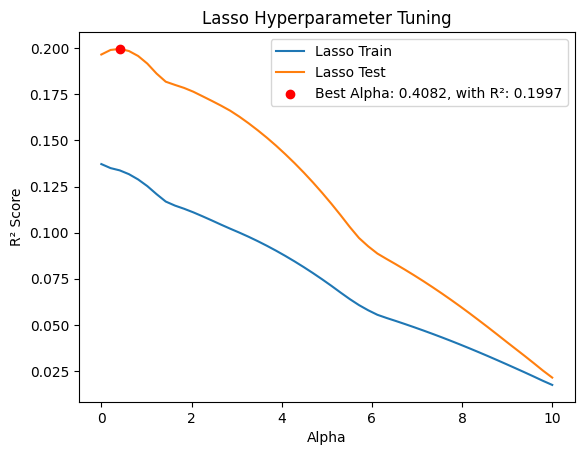

In [ ]:
train, test = HyperparameterTuning(Lasso(), xtrain, ytrain, xtest, ytest, alphas)
plt.plot(alphas, train, label="Lasso Train")
plt.plot(alphas, test, label="Lasso Test")
best_index = np.argmax(test)
best_alpha_value = alphas[best_index]
best_score = test[best_index]
plt.scatter(best_alpha_value, best_score, color='red', zorder=3, label=f"Best Alpha: {best_alpha_value:.4f}, with R²: {best_score:.4f}")
plt.xlabel("Alpha")
plt.ylabel("R² Score")
plt.title("Lasso Hyperparameter Tuning")
plt.legend()
plt.show()


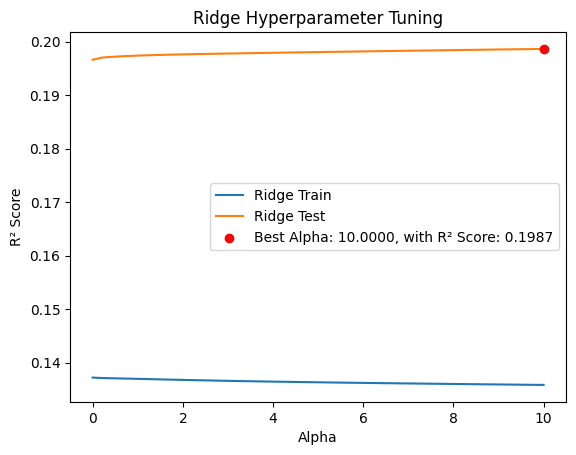

In [ ]:
train, test = HyperparameterTuning(Ridge(), xtrain, ytrain, xtest, ytest, alphas)
plt.plot(alphas, train, label="Ridge Train")
plt.plot(alphas, test, label="Ridge Test")
best_index = np.argmax(test)
best_alpha_value = alphas[best_index]
best_score = test[best_index]
plt.scatter(best_alpha_value, best_score, color='red', zorder=3, label=f"Best Alpha: {best_alpha_value:.4f}, with R² Score: {best_score:.4f}")
plt.xlabel("Alpha")
plt.ylabel("R² Score")
plt.title("Ridge Hyperparameter Tuning")
plt.legend()
plt.show()


In [77]:
# Hyperparameter tuning for RandomForestRegressor

def HyperparameterTuningRandomForestRegressor(xtrain, ytrain, n_estimators, max_depths):

    train_scores = []
    test_scores = []
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    for n_estimator in n_estimators:
        for max_depth in max_depths:
            train_folds = []
            test_folds = []
            for train_idx, test_idx in kf.split(xtrain):
                X_train, X_test = xtrain.iloc[train_idx], xtrain.iloc[test_idx]
                y_train, y_test = ytrain.iloc[train_idx], ytrain.iloc[test_idx]
                model = RandomForestRegressor(n_estimators=n_estimator, max_depth=max_depth)
                model.fit(X_train, y_train)
                y_pred_train = model.predict(X_train)
                y_pred_test = model.predict(X_test)
                train_folds.append(r2_score(y_train, y_pred_train))
                test_folds.append(r2_score(y_test, y_pred_test))
            train_scores.append(np.mean(train_folds))
            test_scores.append(np.mean(test_folds))
    return train_scores, test_scores

n_estimators = [10, 25, 50, 75, 100, 150]
max_depths = [2, 5, 10, 20,50,100, None]

train, test = HyperparameterTuningRandomForestRegressor(xtrain, ytrain, n_estimators, max_depths)





## Let's see some particular values.

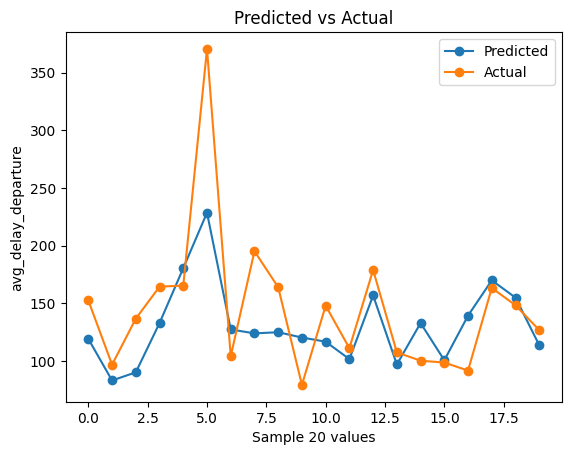

day_sin                    -0.304921
day_cos                     0.952378
holiday                            1
weekend                        False
day_after_rest                 False
avg_temperature             -3.74697
avg_dewpoint               -6.477273
avg_relative_humidity      81.984848
avg_precipitation                0.0
avg_snowfall                     0.0
avg_wind_direction        101.814394
avg_wind_speed             11.033712
avg_pressure             1008.850759
Name: 3268, dtype: object


In [86]:

rf = RandomForestRegressor(n_estimators=100, max_depth=50)
rf.fit(xtrain, ytrain)

new_x = xtest.iloc[80:100]  
new_y = ytest.iloc[80:100]

predictions = rf.predict(new_x)
comparison_df = pd.DataFrame({'Predicted': predictions,'Actual': new_y.values}, index=new_y.index)

plt.plot(predictions, label='Predicted', marker='o')
plt.plot(new_y.values, label='Actual', marker='o')
plt.title("Predicted vs Actual")
plt.xlabel("Sample 20 values")
plt.ylabel("avg_delay_departure")
plt.legend()
plt.show()

print(new_x.iloc[5])


In [89]:
query = """WITH DailyAverageDelays AS (
    SELECT 
        departure_date, 
        AVG(delay_arrival) AS avg_delay_arrival, 
        AVG(delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA
    GROUP BY departure_date
)
SELECT 
    departure_date, 
    avg_delay_arrival, 
    avg_delay_departure, 
    CASE 
        WHEN avg_delay_arrival >= 300 OR avg_delay_departure >= 300 THEN 1 
        ELSE 0 
    END AS delay_flag
FROM DailyAverageDelays;"""

temp =  pd.read_sql(sqla.text(query), connection)
display(temp)

,departure_date,avg_delay_arrival,avg_delay_departure,delay_flag
0,2014-01-01,38.000104,47.338924,0
1,2014-01-02,61.479792,69.302843,0
2,2014-01-03,131.355574,137.877869,0
3,2014-01-04,73.400835,81.274319,0
4,2014-01-05,63.745558,71.634720,0
...,...,...,...,...
4013,2024-12-27,115.032016,118.386998,0
4014,2024-12-28,90.402355,96.597680,0
4015,2024-12-29,57.736765,65.029618,0
4016,2024-12-30,86.974808,90.947700,0


In [90]:
merged_df["delay_flag"] = ((merged_df["avg_delay_arrival"] >= 300) | 
                                  (merged_df["avg_delay_departure"] >= 300)).astype(int)

display(merged_df)


,holiday,weekend,day_after_rest,avg_delay_arrival,avg_delay_departure,avg_temperature,avg_dewpoint,avg_relative_humidity,avg_precipitation,avg_snowfall,avg_wind_direction,avg_wind_speed,avg_pressure,day_sin,day_cos,delay_flag
0,2,False,False,38.000104,47.338924,6.834615,4.222308,84.692308,0.005769,0.0,187.846154,24.132693,1005.357310,1.721336e-02,0.999852,0
1,1,False,False,61.479792,69.302843,8.257252,5.640076,84.694656,0.029008,0.0,202.900763,22.245802,1000.038171,3.442161e-02,0.999407,0
2,1,False,False,131.355574,137.877869,8.838931,5.646947,81.770992,0.017557,0.0,204.809160,26.137023,1003.428245,5.161967e-02,0.998667,0
3,1,True,False,73.400835,81.274319,7.535938,4.859375,84.109375,0.000000,0.0,179.062500,19.125000,1001.156251,6.880243e-02,0.997630,0
4,1,True,False,63.745558,71.634720,4.975379,2.743182,86.128788,0.014015,0.0,206.742424,17.959091,1006.122729,8.596480e-02,0.996298,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4013,1,False,False,115.032016,118.386998,2.355682,0.105303,88.973485,0.000000,0.0,188.662879,4.873864,1033.806809,-5.161967e-02,0.998667,0
4014,1,True,False,90.402355,96.597680,0.447727,-0.890530,91.526515,0.000000,0.0,198.060606,6.454924,1030.597722,-3.442161e-02,0.999407,0
4015,1,True,False,57.736765,65.029618,0.620833,0.399621,98.314394,0.000000,0.0,215.412879,10.555682,1031.240527,-1.721336e-02,0.999852,0
4016,1,False,False,86.974808,90.947700,2.664773,2.418182,98.026515,0.000000,0.0,207.541667,14.429545,1030.950375,6.432491e-16,1.000000,0


In [87]:
def sample_plot(xtrain , ytrain, xtest, ytest):
    rf = RandomForestRegressor(n_estimators=100, max_depth=50, random_state=0)
    rf.fit(xtrain, ytrain)

    new_x = xtest.iloc[0:300]  
    new_y = ytest.iloc[0:300]

    predictions = rf.predict(new_x)
    plt.plot(predictions, label='Predicted', alpha = 0.6)
    plt.plot(new_y.values,label='Actual', alpha = 0.5)
    plt.title("Predicted vs Actual")
    plt.xlabel("Sample 300 values")
    plt.ylabel("avg_delay_departure")
    plt.legend()
    plt.show()

In [91]:
x_strike = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure", "delay_flag"]]
y_strike = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_strike, y_strike, test_size=0.2, random_state=0)

In [92]:
model_test(xtrain,xtest,ytrain,ytest)

Model RandomForestRegressor()
MSE:  1371.9820147868006
MAE:  28.43687403893005
R2:  0.5080793415600351
Model LinearRegression()
MSE:  1791.50726060904
MAE:  32.44179654664083
R2:  0.3576596327498337
Model Lasso()
MSE:  1777.4148825313273
MAE:  32.36890652651848
R2:  0.362712419031475
Model Ridge()
MSE:  1783.135742422461
MAE:  32.41651731871855
R2:  0.36066121928238315
Model SVR()
MSE:  2881.1082454235825
MAE:  37.96559509064546
R2:  -0.033014026314199585
Model DecisionTreeRegressor()
MSE:  2532.3740831155783
MAE:  38.822510322663675
R2:  0.09202371973068657
Model KNeighborsRegressor()
MSE:  3709.612959193972
MAE:  42.71864994545137
R2:  -0.330072282126596


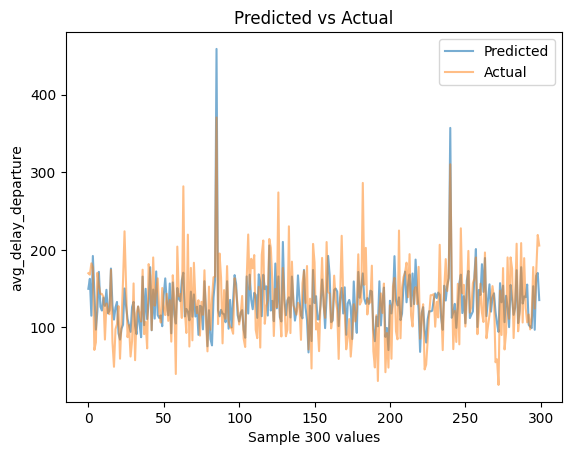

In [93]:
sample_plot(xtrain, ytrain, xtest, ytest)


In [51]:
ones_indices = merged_df[merged_df["delay_flag"] == 1].index

num_to_change = int(len(ones_indices) * 0.1)
random_indices = np.random.choice(ones_indices, size=num_to_change, replace=False)

merged_df.loc[random_indices, "delay_flag"] = 0

In [52]:
x_strike_updated = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure", "delay_flag"]]
y_strike_updated = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_strike_updated, y_strike_updated, test_size=0.2, random_state=0)

Model RandomForestRegressor()
MSE:  1437.6987929263503
MAE:  28.890493198981364
R2:  0.48451675806801764
Model LinearRegression()
MSE:  1820.4465757883618
MAE:  32.6266431381883
R2:  0.3472835149695829
Model Lasso()
MSE:  1845.9396869274165
MAE:  32.722396302538066
R2:  0.33814302487419656
Model Ridge()
MSE:  1816.0804305297013
MAE:  32.622098639669346
R2:  0.3488489852362019
Model SVR()
MSE:  2881.1083869990957
MAE:  37.96559539558054
R2:  -0.03301407707573922
Model DecisionTreeRegressor()
MSE:  2746.7642813975167
MAE:  39.12711949093953
R2:  0.015154659957833494
Model KNeighborsRegressor()
MSE:  3709.612959193972
MAE:  42.71864994545137
R2:  -0.330072282126596


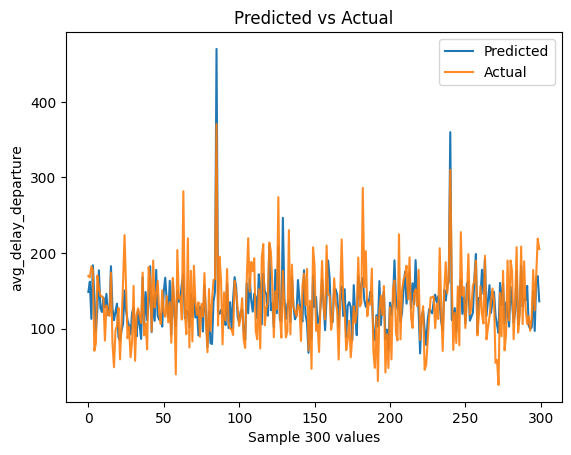

In [53]:
model_test(xtrain,xtest,ytrain,ytest)
sample_plot(xtrain, ytrain, xtest, ytest)

In [54]:
merged_df["delay_flag_2"] = np.select(
    [
        (merged_df["avg_delay_arrival"] < 250) & (merged_df["avg_delay_departure"] < 250),  # Condition for 0
        ((merged_df["avg_delay_arrival"] >= 275) & (merged_df["avg_delay_arrival"] <= 350)) | 
        ((merged_df["avg_delay_departure"] >= 275) & (merged_df["avg_delay_departure"] <= 350)),  # Condition for 1
        (merged_df["avg_delay_arrival"] > 350) | (merged_df["avg_delay_departure"] > 350)  # Condition for 2
    ],
    [0, 1, 2],  # Assign corresponding values
)

delay_flag_counts = merged_df["delay_flag_2"].value_counts()
delay_flag_counts.columns = ["delay_flag_2", "count"]


print(delay_flag_counts)

0    3931
1      54
2      33
Name: delay_flag_2, dtype: int64


In [56]:
x_delayflag = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure", "delay_flag_2"]]
y_delayflag = merged_df["avg_delay_departure"]

xtrain, xtest, ytrain, ytest = train_test_split(x_delayflag, y_delayflag, test_size=0.2, random_state=0)

Model RandomForestRegressor()
MSE:  1956.839632649941
MAE:  28.39655079387716
R2:  0.298380131678211
Model LinearRegression()
MSE:  1593.2685585350866
MAE:  31.245444466405498
R2:  0.42873761467779425
Model Lasso()
MSE:  1576.7530581214974
MAE:  30.924679995988974
R2:  0.434659205303879
Model Ridge()
MSE:  1589.735906433599
MAE:  31.218214693373046
R2:  0.43000423809491917
Model SVR()
MSE:  2881.10634833613
MAE:  37.96559081816877
R2:  -0.03301334611832307
Model DecisionTreeRegressor()
MSE:  16096.00841426293
MAE:  42.22599049705043
R2:  -4.771182837720979
Model KNeighborsRegressor()
MSE:  3690.4647932136577
MAE:  42.55786996265917
R2:  -0.3232067559641283


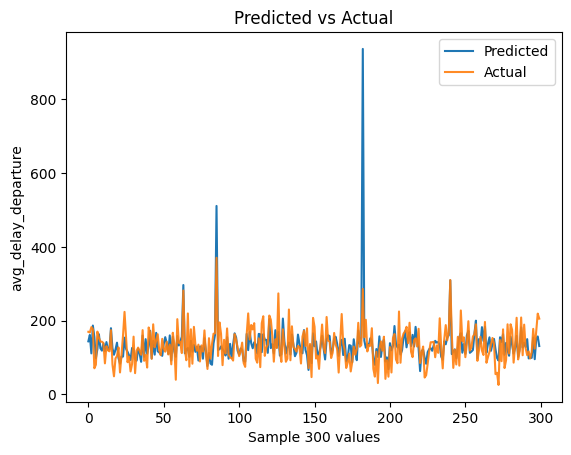

In [57]:
model_test(xtrain,xtest,ytrain,ytest)
sample_plot(xtrain, ytrain, xtest, ytest)